In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sciso.imzml_utils import peaks_df_to_images, extract_peaks
from sciso.spacem_ion_images import IonImages, write_ion_metadata

from sciso.extract_isotopologue_ion_images import get_iso_ion_list

from sciso.plot import *



Set plot style

In [2]:
set_nature_style()

# imzML annotation
Generate list of isotopologues for given molecules, extract ion images and store in the format like in SpaceM

## Set paths

Open ion list based on annotations from Metaspace

In [3]:
ion_list_path = Path("ion_list_fa.csv")
ion_list = pd.read_csv(ion_list_path)
ion_list.head()

,annotation_id,formula,adduct,ionFormula,ion,mz,msm,fdr,databases,moleculeNames,moleculeIds,name,structure
0,C18H36O2-H,C18H36O2,-H,C18H35O2,C18H36O2-H-,283.264215,0.931665,0.05,"[[""SwissLipids"", ""2018-02-02""]]","[""Stearate""]","[""SLM:000000826""]",stearate,“FA 18:0”
1,C18H34O2-H,C18H34O2,-H,C18H33O2,C18H34O2-H-,281.248565,0.924278,0.05,"[[""SwissLipids"", ""2018-02-02""]]","[""Oleate"", ""(9E)-octadecenoate"", ""18:1(11E)"", ...","[""SLM:000000418"", ""SLM:000389844"", ""SLM:000001...",oleate,“FA 18:1”
2,C16H32O2-H,C16H32O2,-H,C16H31O2,C16H32O2-H-,255.232915,0.892784,0.05,"[[""SwissLipids"", ""2018-02-02""]]","[""Palmitate""]","[""SLM:000000510""]",palmitate,“FA 16:0”
3,C16H30O2-H,C16H30O2,-H,C16H29O2,C16H30O2-H-,253.217265,0.861395,0.05,"[[""SwissLipids"", ""2018-02-02""]]","[""16:1(6Z)"", ""16:1(9Z)""]","[""SLM:000000550"", ""SLM:000000411""]",FA 16:1,“FA 16:1”
4,C14H28O2-H,C14H28O2,-H,C14H27O2,C14H28O2-H-,227.201614,0.874477,0.05,"[[""SwissLipids"", ""2018-02-02""]]","[""Myristate""]","[""SLM:000000825""]",myristate,“FA 14:0”


Path to data

Example dataset: hypoxia slide 3, well 4 - mixture of normoxia and hypoxia

In [15]:
data_dir = Path(r"/media/buglakova/embl_data/data/lipid_isotope/20220322_AB_DKFZHypoxia")
spacem_dir = data_dir / "slide2" / "spacem_data" / "W8"

imzml_path = spacem_dir / "MassSpectrometry"
imzml_path = list(imzml_path.glob("*.imzML"))[0]

output_dir = data_dir / "ion_images_example"
output_dir.mkdir(parents=True, exist_ok=True)

## Generate list of all possible isotopologues

In [16]:
metadata_new = get_iso_ion_list(ion_list)

In [17]:
metadata_new.head()

,annotation_id,formula,adduct,ionFormula,ion,mz,msm,fdr,databases,moleculeNames,moleculeIds,name,structure,unlabeled_annotation_id,M+,dm
0,C18H36O2-H,C18H36O2,-H,C18H35O2,C18H36O2-H-,283.264215,0.931665,0.05,"[[""SwissLipids"", ""2018-02-02""]]","[""Stearate""]","[""SLM:000000826""]",stearate,“FA 18:0”,C18H36O2-H,0,0.000000
1,[13C]C17H36O2-H,[13C]C17H36O2,-H,[13C]C17H35O2,[13C]C17H36O2-H-,284.267570,0.931665,0.05,"[[""SwissLipids"", ""2018-02-02""]]","[""Stearate""]","[""SLM:000000826""]",stearate,“FA 18:0”,C18H36O2-H,1,1.003355
2,[13C]2C16H36O2-H,[13C]2C16H36O2,-H,[13C]2C16H35O2,[13C]2C16H36O2-H-,285.270925,0.931665,0.05,"[[""SwissLipids"", ""2018-02-02""]]","[""Stearate""]","[""SLM:000000826""]",stearate,“FA 18:0”,C18H36O2-H,2,2.006710
3,[13C]3C15H36O2-H,[13C]3C15H36O2,-H,[13C]3C15H35O2,[13C]3C15H36O2-H-,286.274280,0.931665,0.05,"[[""SwissLipids"", ""2018-02-02""]]","[""Stearate""]","[""SLM:000000826""]",stearate,“FA 18:0”,C18H36O2-H,3,3.010065
4,[13C]4C14H36O2-H,[13C]4C14H36O2,-H,[13C]4C14H35O2,[13C]4C14H36O2-H-,287.277635,0.931665,0.05,"[[""SwissLipids"", ""2018-02-02""]]","[""Stearate""]","[""SLM:000000826""]",stearate,“FA 18:0”,C18H36O2-H,4,4.013420


## Extract ion images

As an example, check how different tolerance changes ion images

In [18]:
ion_images_objs = {}
for tol in [3, 5, 10]:
    print(tol)
    coords_df, peaks = extract_peaks(imzml_path, metadata_new, tol_ppm=tol, tol_mode="orbitrap", base_mz=200)

    images = []
    for peak in peaks:
        image = peaks_df_to_images(coords_df, peak["peaks_df"])
        images.append(image[1].T)
    images = np.array(images)

    ion_images_obj = IonImages(metadata=metadata_new, shape=images.shape[1:3], array=images)
    ion_images_objs[tol] = ion_images_obj


3
5
10


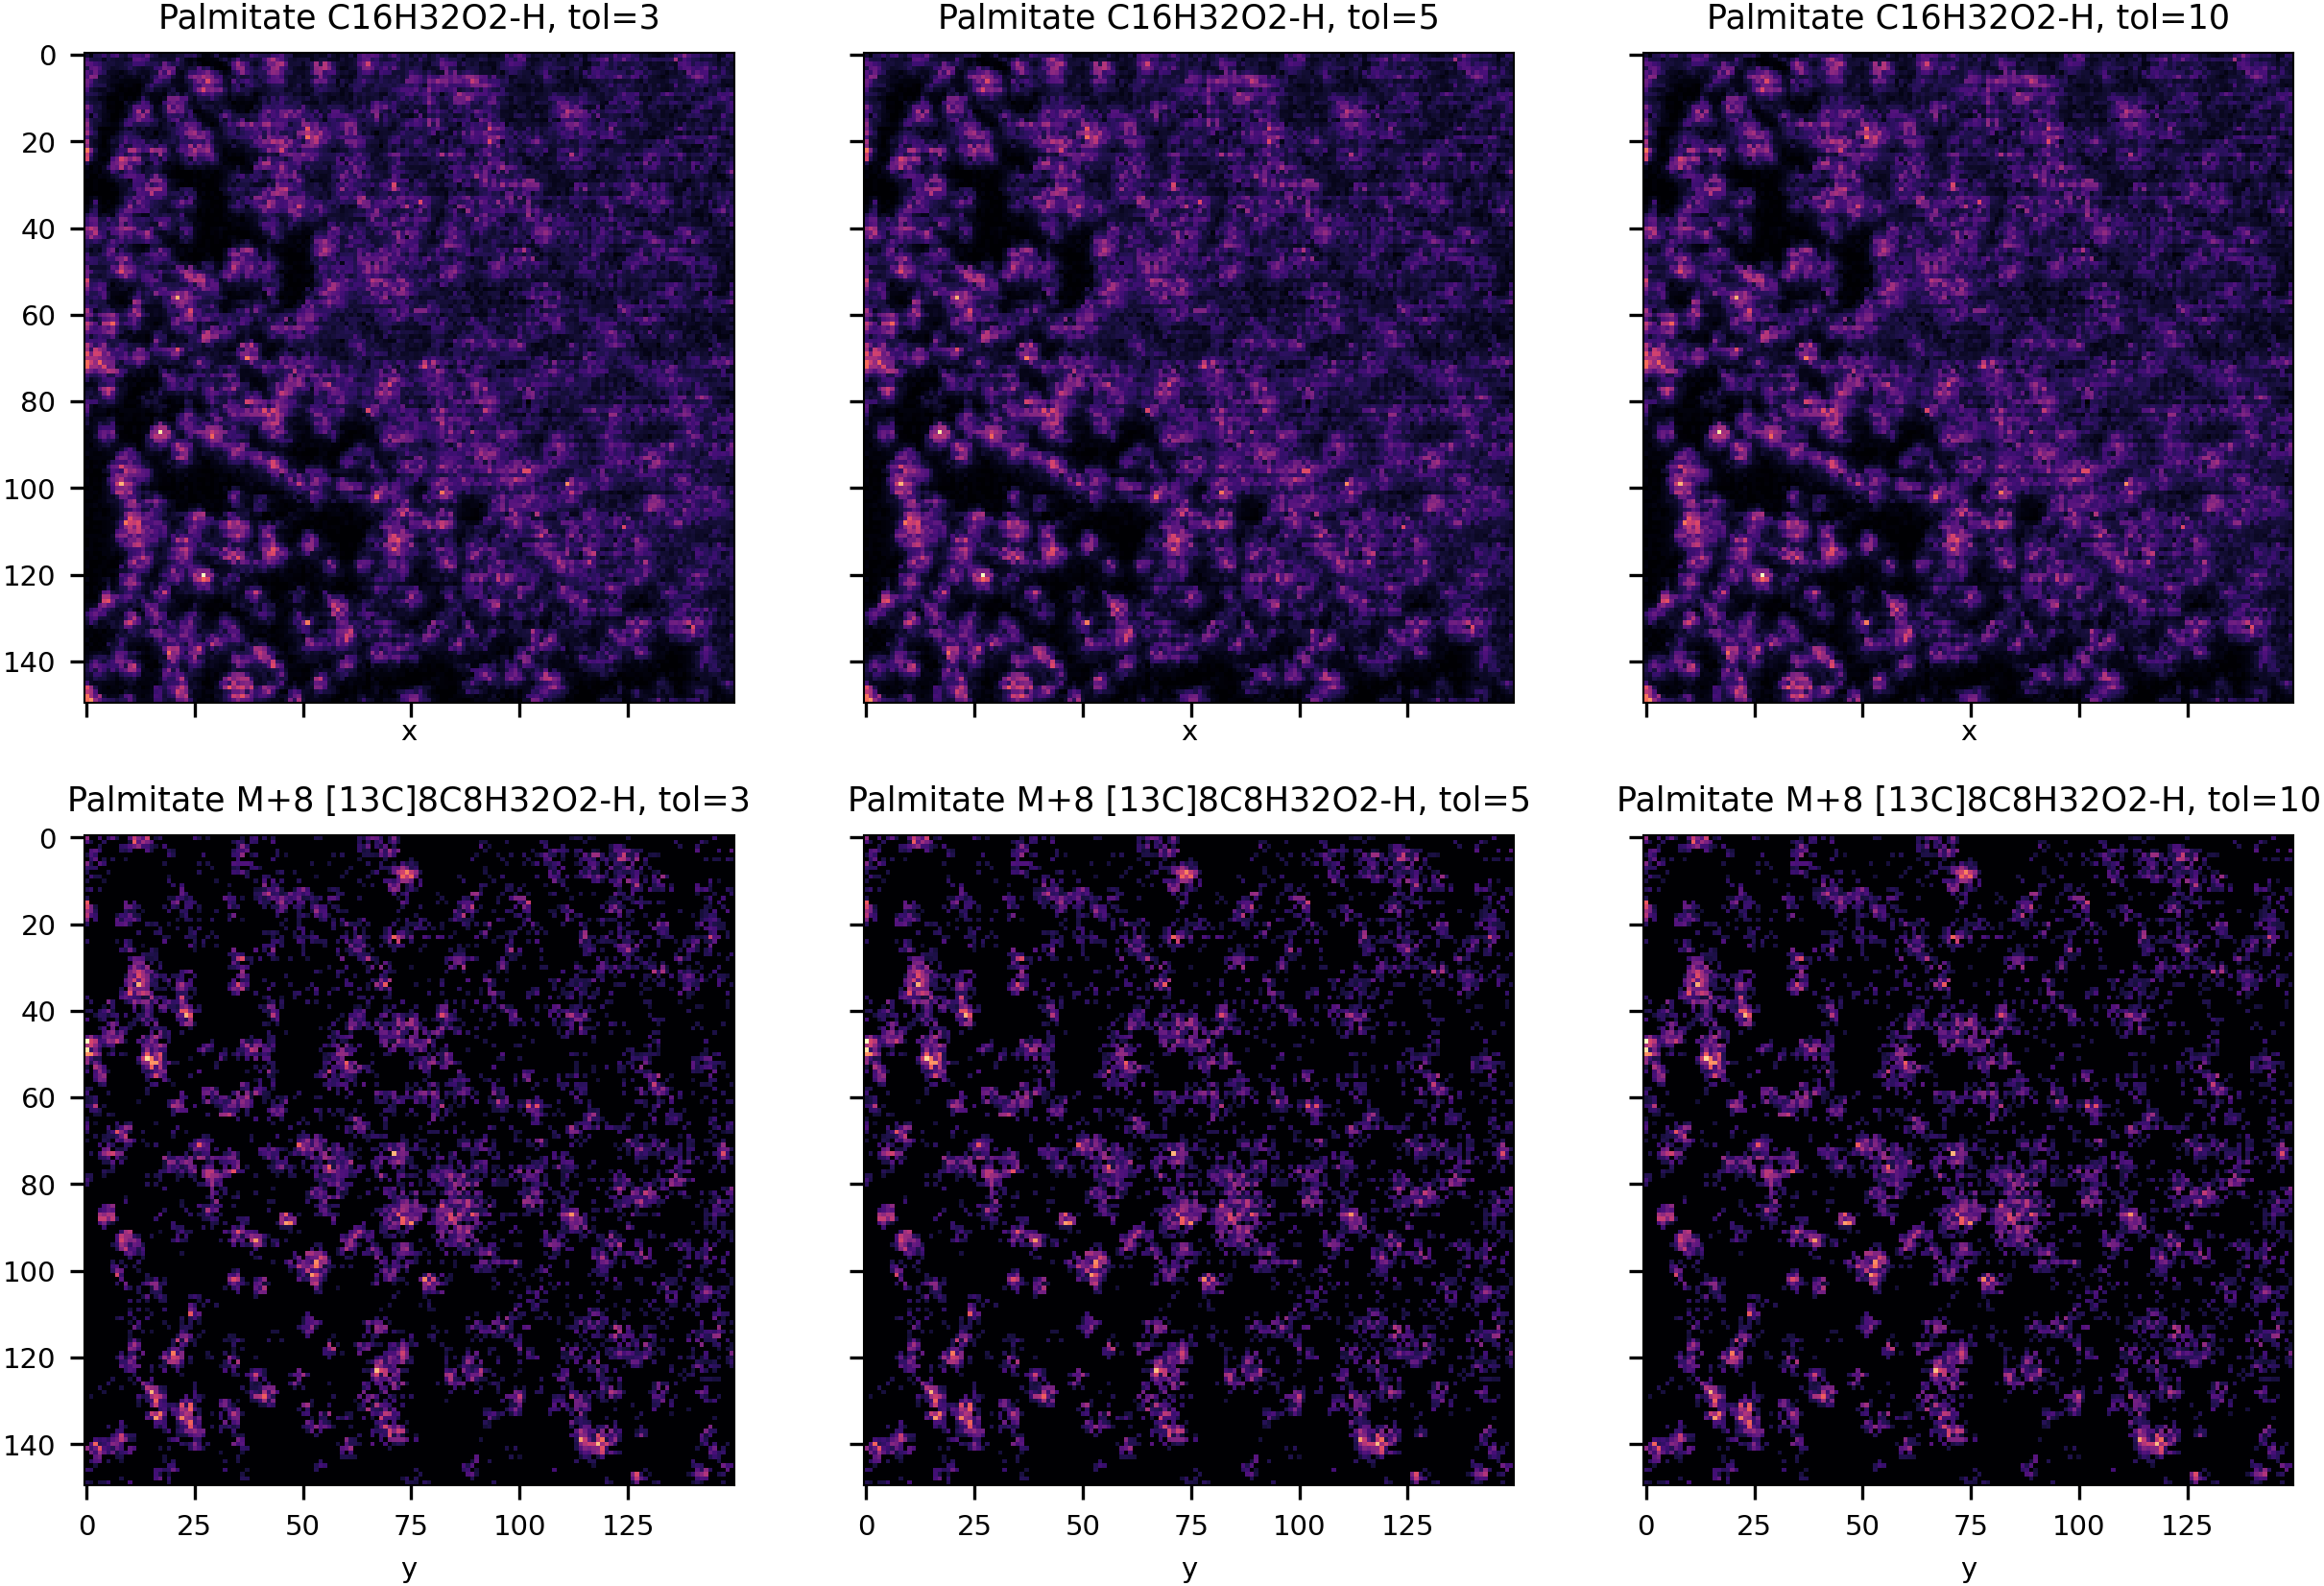

In [19]:
palmitate = "C16H32O2-H"
# Palmitate M+8
palmitate_8 = "[13C]8C8H32O2-H"

fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(x_width * 3, x_width * 2))

for idx, tol in enumerate([3, 5, 10]):
    axs[0, idx].imshow(ion_images_objs[tol].get_for_ion(palmitate))
    axs[0, idx].set_title(f"Palmitate {palmitate}, tol={tol}")
    axs[0, idx].set_xlabel("x")
    axs[1, idx].imshow(ion_images_objs[tol].get_for_ion(palmitate_8))
    axs[1, idx].set_title(f"Palmitate M+8 {palmitate_8}, tol={tol}")
    axs[1, idx].set_xlabel("y")
    
fig.savefig(output_dir / "palmitate_heatmaps.svg")
fig.savefig(output_dir / "palmitate_heatmaps.png")
    

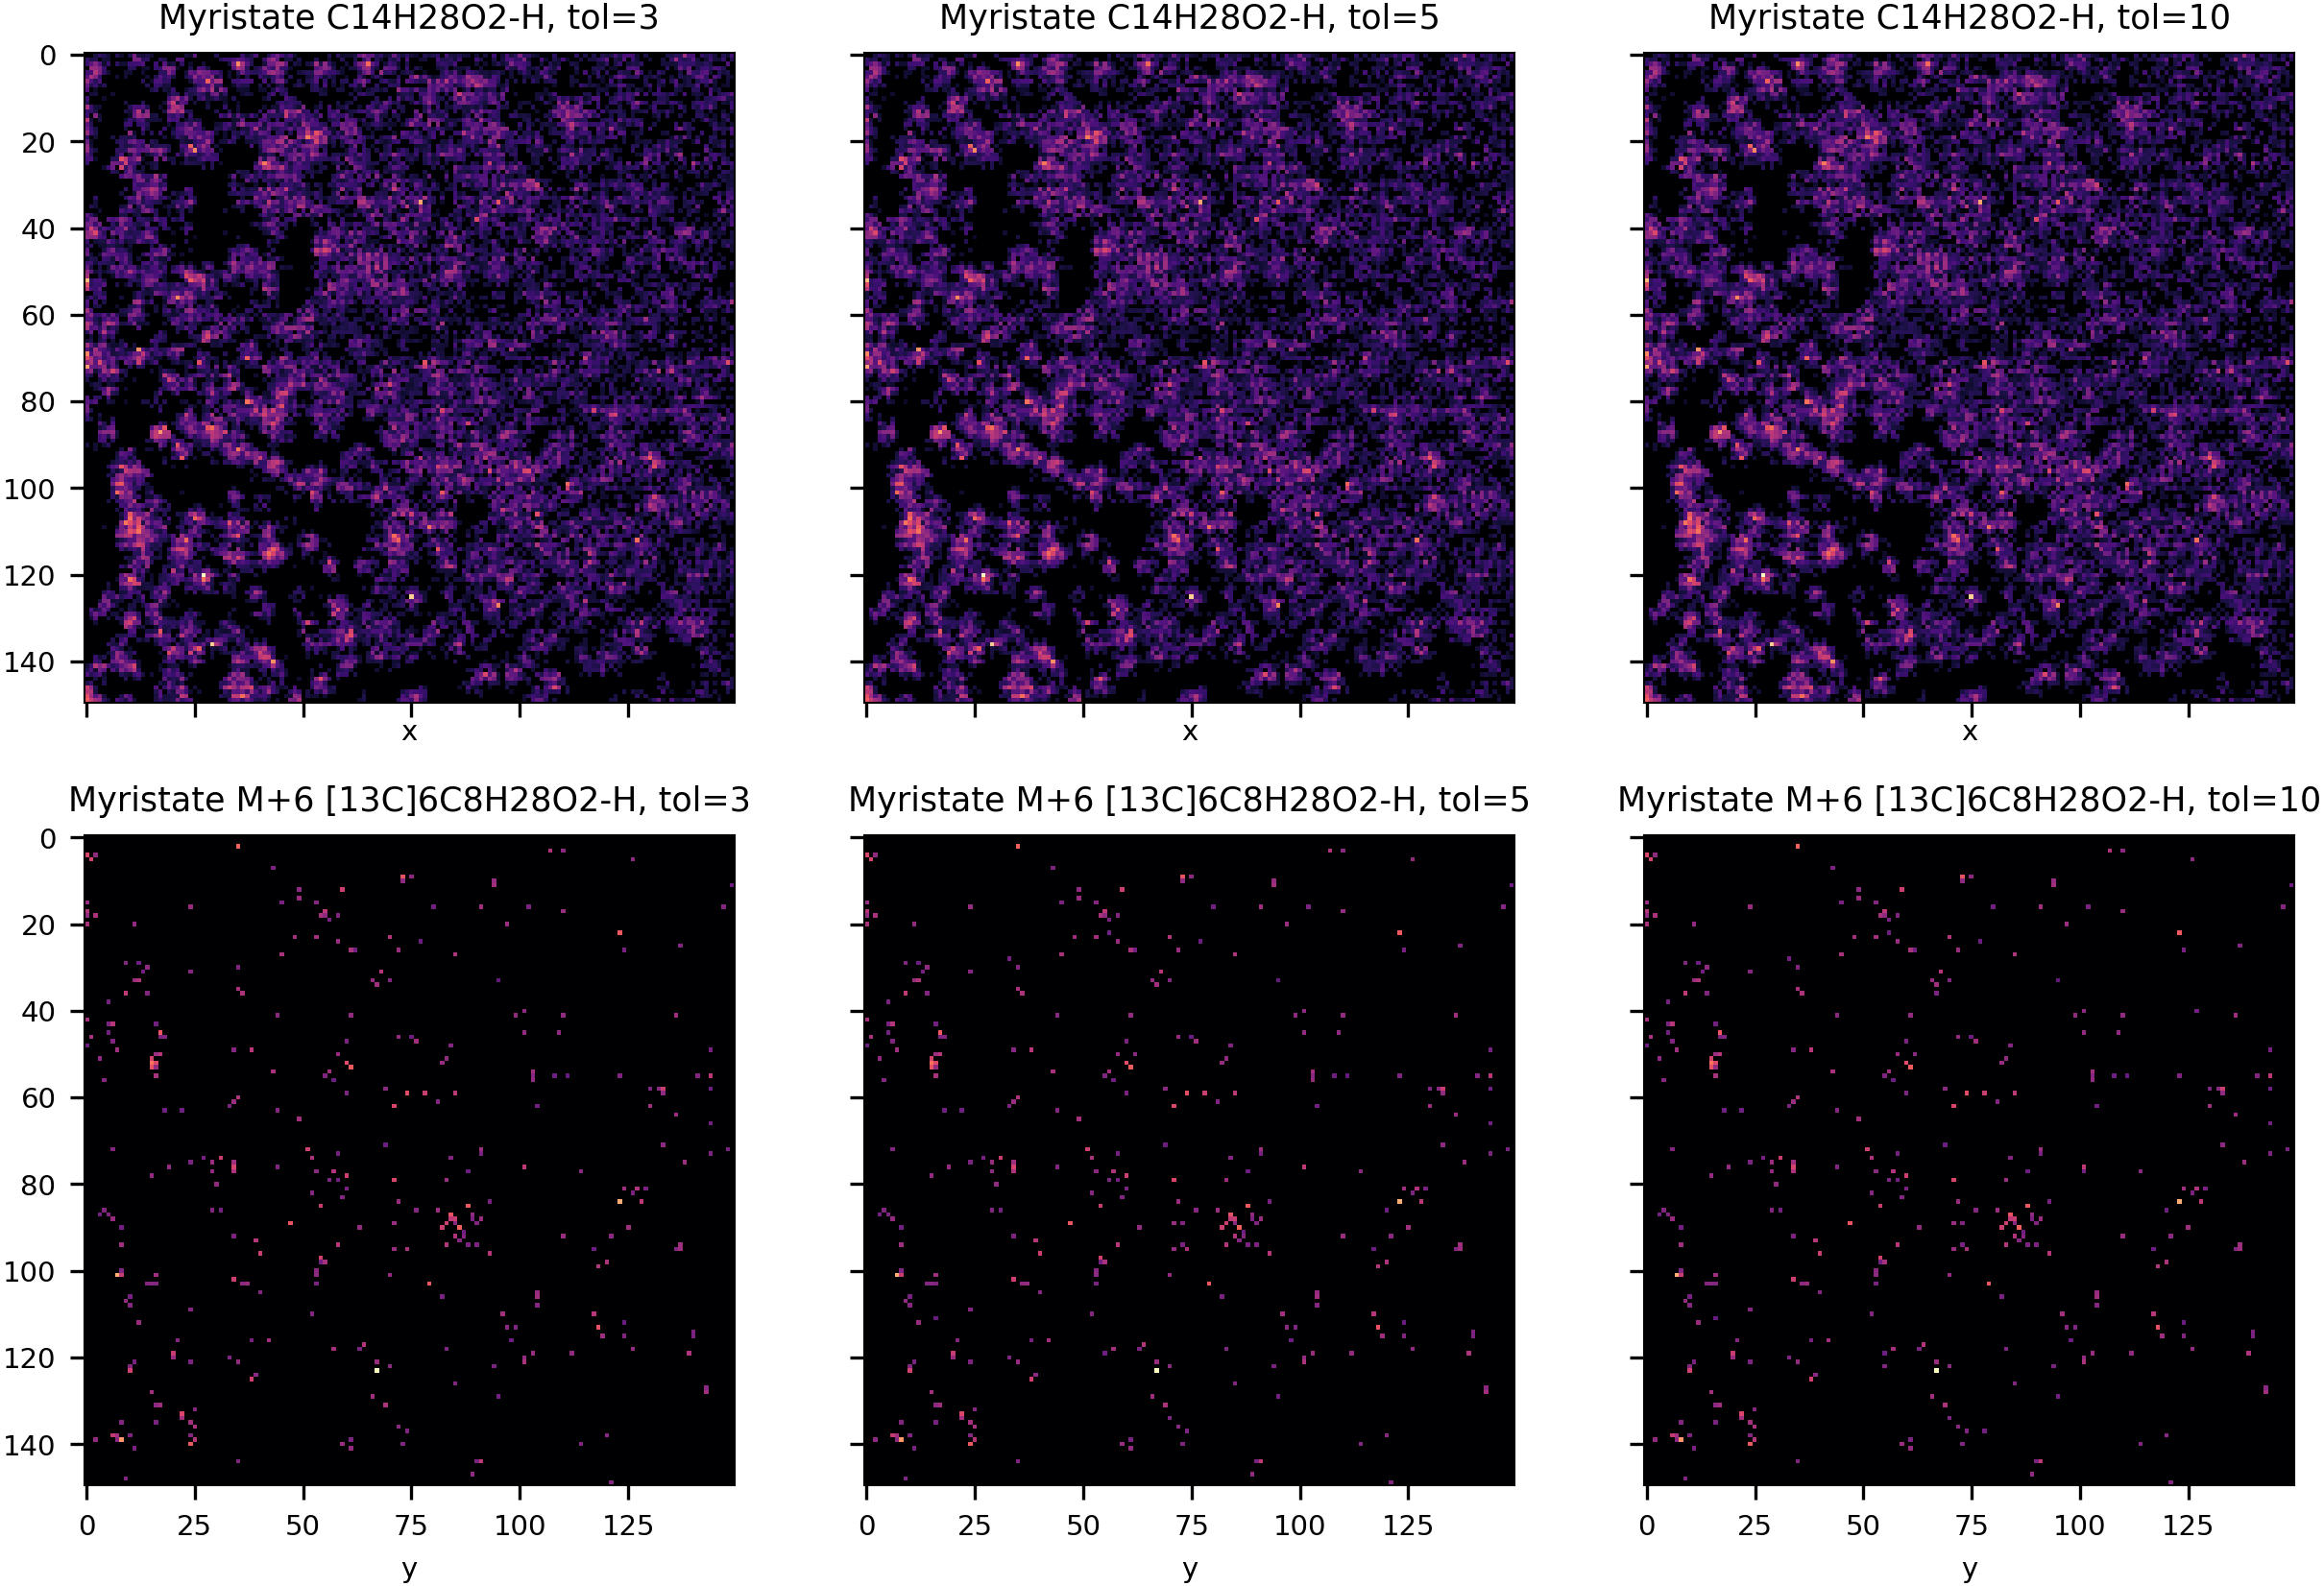

In [22]:
myristate = "C14H28O2-H"
# Myristate M+6
myristate_6 = "[13C]6C8H28O2-H"

fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(x_width * 3, x_width * 2))

for idx, tol in enumerate([3, 5, 10]):
    axs[0, idx].imshow(ion_images_objs[tol].get_for_ion(myristate))
    axs[0, idx].set_title(f"Myristate {myristate}, tol={tol}")
    axs[0, idx].set_xlabel("x")
    axs[1, idx].imshow(ion_images_objs[tol].get_for_ion(myristate_6))
    axs[1, idx].set_title(f"Myristate M+6 {myristate_6}, tol={tol}")
    axs[1, idx].set_xlabel("y")
    
fig.savefig(output_dir / "myristate_heatmaps.svg")
fig.savefig(output_dir / "myristate_heatmaps.png")
    

## Plot extracted peaks in one pixel

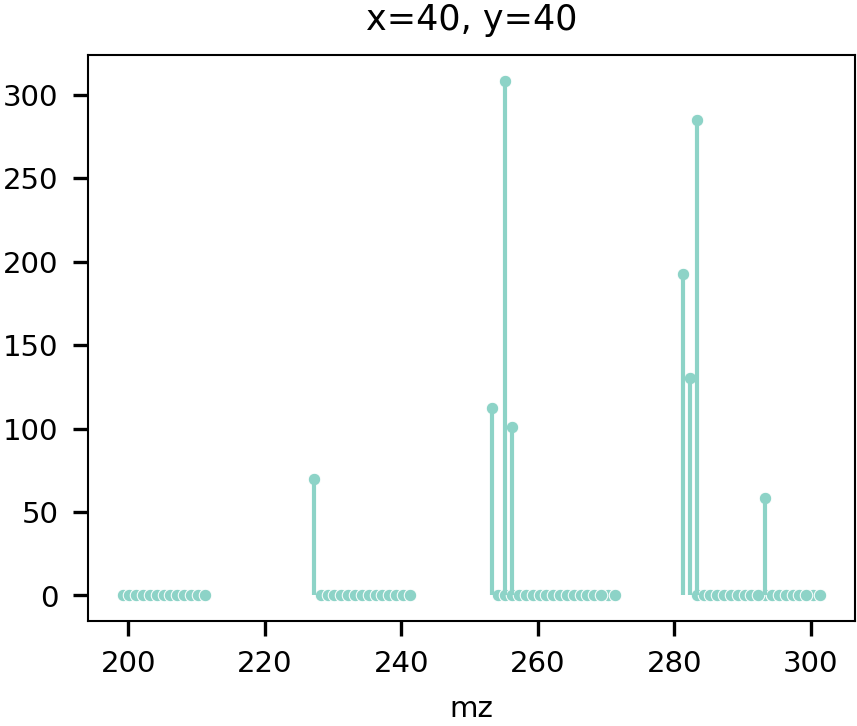

In [21]:
x = 40
y = 40
pixel_spectrum = ion_images_objs[3].get_for_pixel(x=x, y=y)
sns.scatterplot(x=metadata_new.mz, y=pixel_spectrum)
plt.vlines(metadata_new.mz, np.zeros_like(pixel_spectrum), pixel_spectrum)
plt.title(f"x={x}, y={y}")
plt.savefig(output_dir / "extracted_peaks_example.svg")
plt.savefig(output_dir / "extracted_peaks_example.png")

## Save and load ion image object

In [31]:
ion_images_path = output_dir / "ion_images.pickle"
ion_images_metadata_path = output_dir / "ion_images_metadata.csv"
    
with open(ion_images_path, "wb") as f:
    pickle.dump(ion_images_obj, f)
    
write_ion_metadata(ion_images_obj.metadata, ion_images_metadata_path)

In [32]:
with open(ion_images_path, "rb") as f:
    ion_images_obj = pickle.load(f)

Text(0.5, 1.0, 'x=40, y=40')

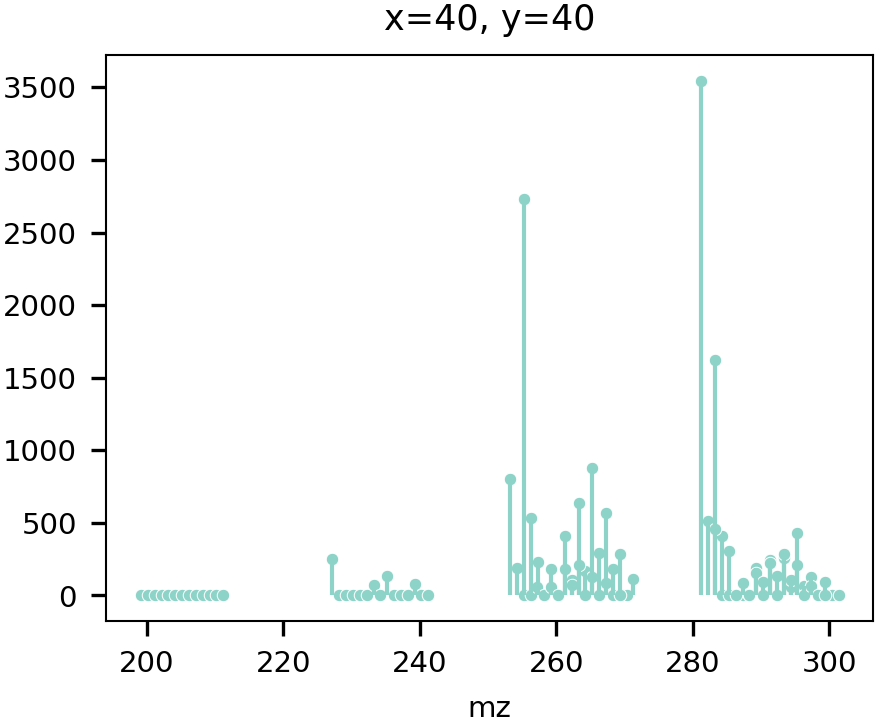

In [34]:
x = 40
y = 40
pixel_spectrum = ion_images_obj.get_for_pixel(x=x, y=y)
sns.scatterplot(x=metadata_new.mz, y=pixel_spectrum)
plt.vlines(metadata_new.mz, np.zeros_like(pixel_spectrum), pixel_spectrum)
plt.title(f"x={x}, y={y}")